(deconvolution:extract_psf)=
# Determining the point-spread-function from a bead image by averaging
In order to deconvolve a microsocpy image properly, we should determine the point-spread-function (PSF) of the microscope.

See also 
* [PSF destilling by Brian Northan](https://github.com/True-North-Intelligent-Algorithms/tnia-python/blob/main/notebooks/Deconvolution/extract_psf-Haase-beads.ipynb)

In [1]:
import numpy as np
from skimage.io import imread, imsave
from pyclesperanto_prototype import imshow
import pyclesperanto_prototype as cle
import pandas as pd
import matplotlib.pyplot as plt

The example image data used here was acquired by Bert Nitzsche and Robert Haase (both MPI-CBG at that time) at the Light Microscopy Facility of MPI-CBG. Just for completeness, the voxel size is 0.022x0.022x0.125 µm^3.

In [2]:
bead_image = imread('../../data/Bead_Image1_crop.tif')
bead_image.shape

(41, 150, 150)

Our example image shows fluorescent beads, ideally with a diameter smaller than the resolution of the imaging setup. Furthermore, the beads should emit light in the same wavelength as the sample we would like to deconvolve later on. In the following image crop we see four fluorescent beads. It is recommended to image a larger field of view, with at least 25 beads. Also make sure that the beads do not stick to each other and are sparsely distributed.

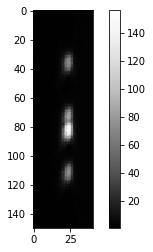

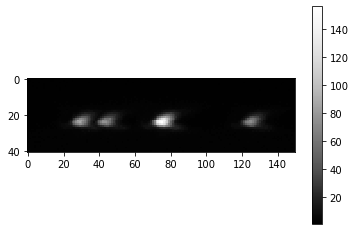

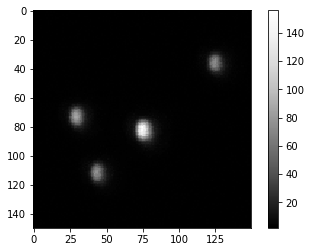

In [3]:
imshow(cle.maximum_x_projection(bead_image), colorbar=True)
imshow(cle.maximum_y_projection(bead_image), colorbar=True)
imshow(cle.maximum_z_projection(bead_image), colorbar=True)

For determining an average PSF, technically we can crop out all the individual beads, align them and then average the images. Therefore, we segment the objects and determine their center of mass.

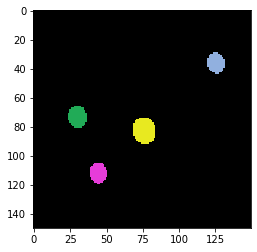

In [4]:
# Segment objects
label_image = cle.voronoi_otsu_labeling(bead_image)
imshow(label_image, labels=True)

In [5]:
# determine center of mass for each object
stats = cle.statistics_of_labelled_pixels(bead_image, label_image)

df = pd.DataFrame(stats)
df[["mass_center_x", "mass_center_y", "mass_center_z"]]

,mass_center_x,mass_center_y,mass_center_z
0,30.107895,73.028938,23.327475
1,44.293156,111.633430,23.329062
2,76.092850,82.453033,23.299677
3,125.439606,35.972496,23.390951


## PSF averaging
Next, we will iterate over the beads and crop them out by translating them into a smaller PSF image.

Bead 0 at position 30.107894897460938 73.02893829345703 23.32747459411621
Bead 1 at position 44.293155670166016 111.63343048095703 23.32906150817871
Bead 2 at position 76.09284973144531 82.45303344726562 23.2996768951416
Bead 3 at position 125.43960571289062 35.972496032714844 23.39095115661621


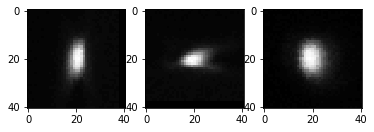

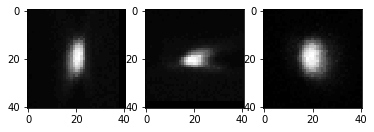

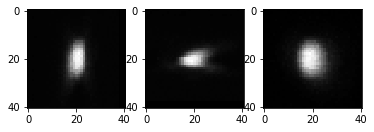

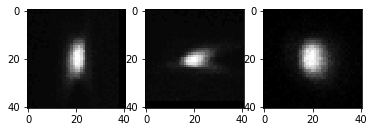

In [6]:
# configure size of future PSF image
psf_radius = 20
size = psf_radius * 2 + 1

# initialize PSF
single_psf_image = cle.create([size, size, size])
avg_psf_image = cle.create([size, size, size])

num_psfs = len(df)
for index, row in df.iterrows():
    x = row["mass_center_x"]
    y = row["mass_center_y"]
    z = row["mass_center_z"]
    
    print("Bead", index, "at position", x, y, z)
    
    # move PSF in right position in a smaller image
    cle.translate(bead_image, single_psf_image, 
                  translate_x= -x + psf_radius,
                  translate_y= -y + psf_radius,
                  translate_z= -z + psf_radius)

    # visualize
    fig, axs = plt.subplots(1,3)    
    imshow(cle.maximum_x_projection(single_psf_image), plot=axs[0])
    imshow(cle.maximum_y_projection(single_psf_image), plot=axs[1])
    imshow(cle.maximum_z_projection(single_psf_image), plot=axs[2])
    
    # average
    avg_psf_image = avg_psf_image + single_psf_image / num_psfs

The average PSF then looks like this:

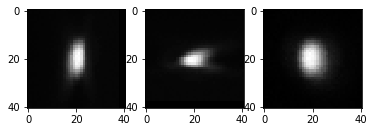

In [7]:
fig, axs = plt.subplots(1,3)    
imshow(cle.maximum_x_projection(avg_psf_image), plot=axs[0])
imshow(cle.maximum_y_projection(avg_psf_image), plot=axs[1])
imshow(cle.maximum_z_projection(avg_psf_image), plot=axs[2])

In [8]:
avg_psf_image.min(), avg_psf_image.max()

(0.0, 94.5)

After we determined a well centered PSF, we can save it for later re-use. Before doing that, we normalize the PSF. Goal is to have an image where the total intensity is `1`. This makes sure that an image that is deconvolved using this PSF later on does not modify the image's intensity range.

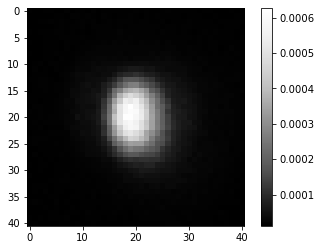

In [9]:
normalized_psf = avg_psf_image / np.sum(avg_psf_image)

imshow(normalized_psf, colorbar=True)

In [10]:
normalized_psf.min(), normalized_psf.max()

(0.0, 0.0006259646)

In [11]:
imsave('../../data/psf.tif', normalized_psf)

C:\Users\rober\AppData\Local\Temp\ipykernel_16716\3265681491.py:1: UserWarning: ../../data/psf.tif is a low contrast image
  imsave('../../data/psf.tif', normalized_psf)
